# [学习JVM是如何从入门到放弃的？(修订版)](https://mp.weixin.qq.com/s?__biz=MzI4Njg5MDA5NA==&mid=2247484721&idx=2&sn=73b2762abd8c54cdc8b6bb8b5692384b&chksm=ebd74430dca0cd262c0cd72509e8e9df71287eb74d3e3e56430934df7c60db38a78824a80a4a&token=1676899695&lang=zh_CN###rd)

## 先来看看简单的Java程序
可以在命令行用`javac`来编译 `.java`文件代码，用 `java` 命令来执行编译后生成的 .class文件。

在使用**IDE**点击运行的时候其实就是将这两个命令**结合**起来了(编译并运行)，方便我们开发。

In [3]:
public class JavaClass{
    private String name;
    private int age;
    //...some getter/setter and toString
    public void setName(String name){
        this.name = name;
    }
    
    public String getName(){
        return name;
    } 
    
    public void setAge(int age){
        this.age = age;
    }
    
    public int getAge(){
        return age;
    }
    
    public String toString(){
        return "name："+name+ "\n"+
        "age："+age;
    }
}

In [6]:
// Test class
public class JavaClassTest{
    public static void test(){
    
        JavaClass javaClass = new JavaClass();
        javaClass.setName("anlzou");
        System.out.println(javaClass);
    }
}

JavaClassTest.test();

name：anlzou
age：0


## 编译过程
`.java`文件是由Java源码编译器(上述所说的javac.exe)来完成，流程图如下所示：
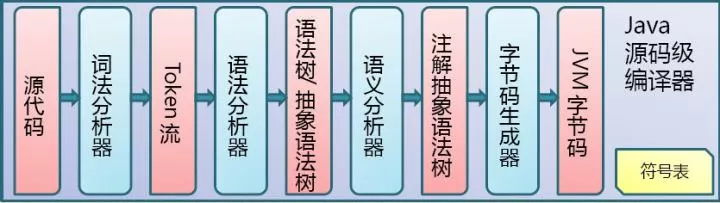
Java源码编译由以下三个过程组成：
- 分析和输入到符号表
- 注解处理
- 语义分析和生成class文件
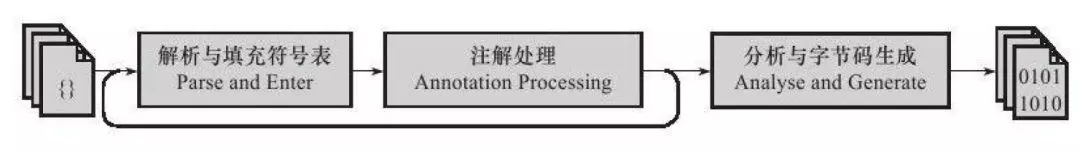

### 编译时期-语法糖
> 语法糖可以看做是**编译器实现的一些“小把戏”**，这些“小把戏”可能会使得**效率“大提升”。**

最值得说明的就是**泛型**了，这个语法糖可以说我们是经常会使用到的！

泛型只会在Java源码中存在，**编译过后**会被替换为原来的原生类型（Raw Type，也称为裸类型）了。这个过程也被称为：**泛型擦除。**

有了泛型这颗语法糖以后：
- 代码更加简洁（不用强制转换）
- 程序更加健壮（只要编译时期没有警告，那么运行时期就不会出现ClassCastException异常）
- 可读性和稳定性（在编写集合的时候，就限定了类型）
